# Import Modules

In [1]:
!pip install utils

In [2]:
!pip install livelossplot

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from livelossplot.inputs.tf_keras import PlotLossesCallback
import tensorflow as tf
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,Conv2D
from tensorflow.keras.layers import BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG,Image
#from livelossplot import PlotLossesTensorFlowKeras
print("Tensorflow version:",tf.__version__)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Tensorflow version: 2.12.0


# Load and Explore the Dataset

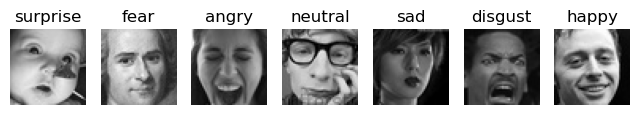

In [4]:
i=1
plt.figure(figsize=(8,8))
for expression in os.listdir('../input/face-expression-recognition-dataset/images/validation/'):
    img=load_img(('../input/face-expression-recognition-dataset/images/validation/'+expression+'/'+os.listdir('../input/face-expression-recognition-dataset/images/validation/'+expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i+=1

plt.show()

In [5]:
#check the amount of data in each folder in training dataset
for expression in os.listdir('../input/face-expression-recognition-dataset/images/train/'):
    print(expression,"folder contains\t\t",len(os.listdir('../input/face-expression-recognition-dataset/images/train/'+expression)),"images")

surprise folder contains		 3205 images
fear folder contains		 4103 images
angry folder contains		 3993 images
neutral folder contains		 4982 images
sad folder contains		 4938 images
disgust folder contains		 436 images
happy folder contains		 7164 images


In [6]:
#check the amount of data in each folder in testing dataset
for expression in os.listdir('../input/face-expression-recognition-dataset/images/validation/'):
    print(expression,"folder contains\t\t",len(os.listdir('../input/face-expression-recognition-dataset/images/validation/'+expression)),"images")

surprise folder contains		 797 images
fear folder contains		 1018 images
angry folder contains		 960 images
neutral folder contains		 1216 images
sad folder contains		 1139 images
disgust folder contains		 111 images
happy folder contains		 1825 images


# Augmentation and Preprocessing

In [7]:
#Data Augmentation
datagen_train=ImageDataGenerator(rescale=1./255,
                                 zoom_range=0.3,
                                 horizontal_flip=True)

train_generator=datagen_train.flow_from_directory('../input/face-expression-recognition-dataset/images/train/',
                                                 batch_size=64,
                                                 target_size=(48,48),
                                                 shuffle=True,
                                                 color_mode='grayscale',
                                                 class_mode='categorical')

datagen_test=ImageDataGenerator(rescale=1./255,
                                 zoom_range=0.3,
                                 horizontal_flip=True)

test_generator=datagen_test.flow_from_directory('../input/face-expression-recognition-dataset/images/validation/',
                                                 batch_size=64,
                                                 target_size=(48,48),
                                                 shuffle=True,
                                                 color_mode='grayscale',
                                                 class_mode='categorical')

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Build the CNN model

In [8]:
model=tf.keras.models.Sequential()

model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(128,kernel_size=(5,5),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(512,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(512,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7,activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0005),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)      5

# Training and Saving the model

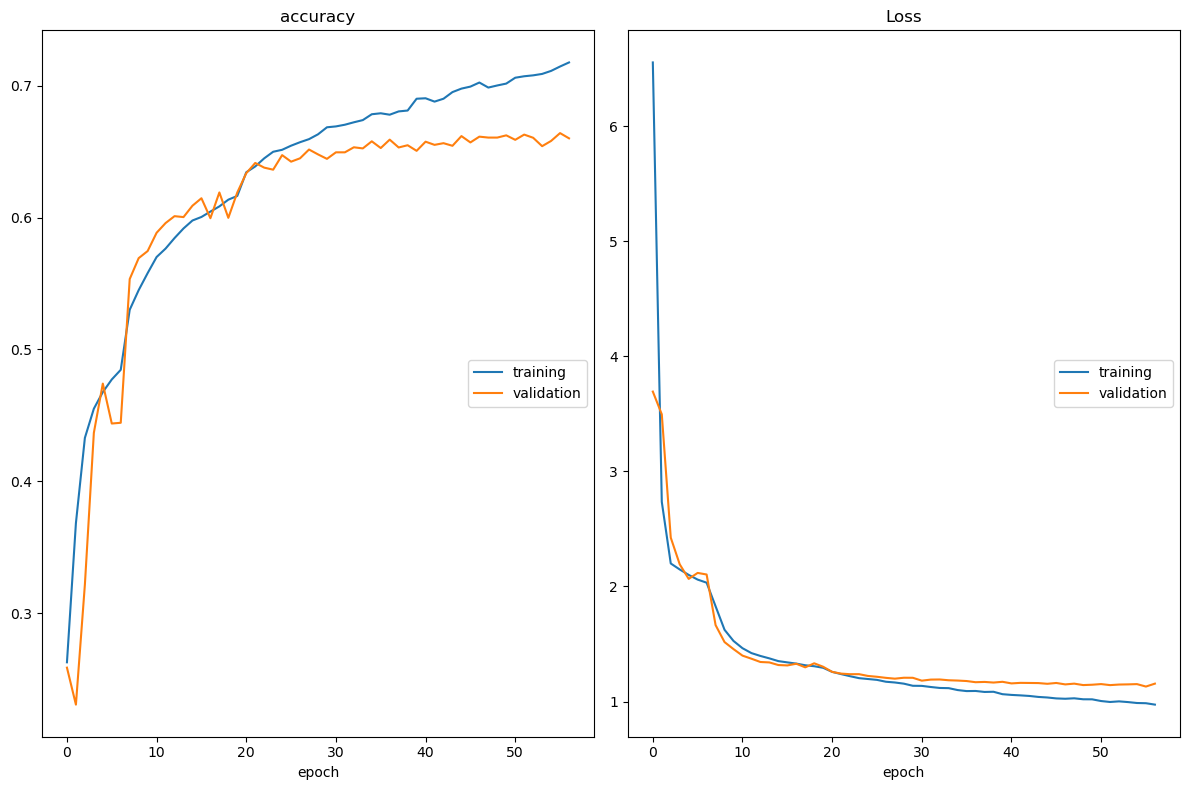

accuracy
	training         	 (min:    0.263, max:    0.718, cur:    0.718)
	validation       	 (min:    0.231, max:    0.664, cur:    0.660)
Loss
	training         	 (min:    0.973, max:    6.553, cur:    0.973)
	validation       	 (min:    1.130, max:    3.693, cur:    1.156)

Epoch 57: saving model to model_weights.h5
450/450 [==============================] - 71s 158ms/step - loss: 0.9734 - accuracy: 0.7176 - val_loss: 1.1556 - val_accuracy: 0.6601 - lr: 1.0000e-05


In [9]:
epochs=57
steps_per_epoch=train_generator.n/train_generator.batch_size
testing_steps=test_generator.n/test_generator.batch_size

checkpoint=ModelCheckpoint("model_weights.h5",monitor="val_accuracy",save_weights_only=True,mode='max',verbose=1)
reduce_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=0.00001,model='auto')

callbacks=[PlotLossesCallback(),checkpoint,reduce_lr]

history=model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=testing_steps,
    callbacks=callbacks
)

# Evaluation

**Training and validation loss curves**

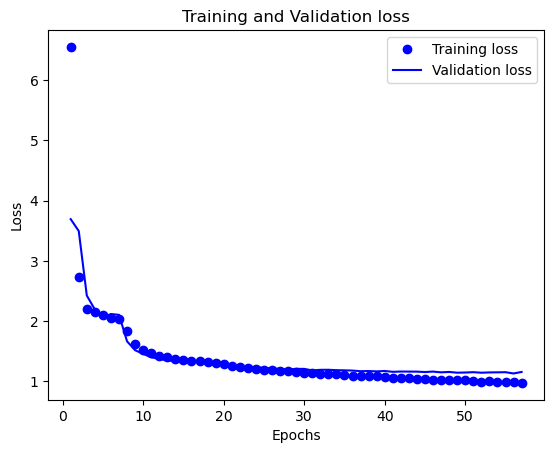

In [10]:
#plot the train and validation loss
train_loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(train_loss)+1)
plt.plot(epochs,train_loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Training and Validation accuracy curves**

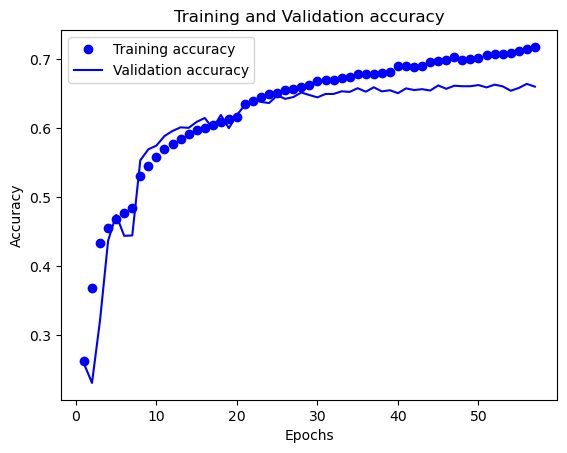

In [11]:
#plot the train and validation accuracy
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
plt.plot(epochs,train_acc,'bo',label='Training accuracy')
plt.plot(epochs,val_acc,'b',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix

111/111 [==============================] - 14s 123ms/step


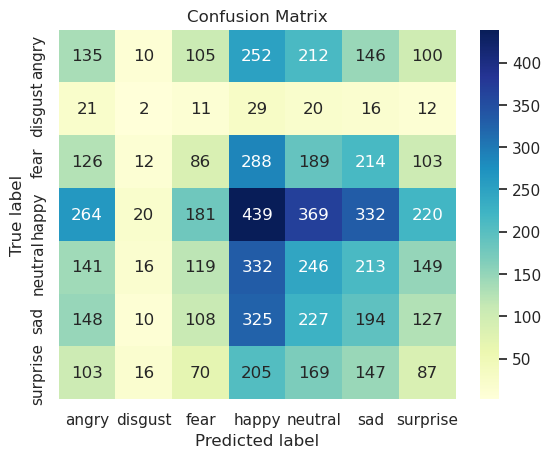

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Get the true labels and predicted labels for the validation set
validation_labels=test_generator.classes
validation_pred_probs=model.predict(test_generator)
validation_pred_labels=np.argmax(validation_pred_probs,axis=1)

#compute the confusion matrix
cm=confusion_matrix(validation_labels,validation_pred_labels)
class_names=list(train_generator.class_indices.keys())
sns.set()
sns.heatmap(cm,annot=True,fmt='d',cmap='YlGnBu',
            xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [13]:
label_dict={0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

In [14]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
def prediction(url):
    img=plt.imread(url)
    plt.imshow(img)
    data=img_to_array(img)
    data=data/255
    data=tf.image.resize(data,(48,48))
    samples=np.expand_dims(data,0)
    samples=np.resize(samples,(1,48,48,1))
    result=model.predict(samples)
    result=list(result[0])
    print(result)
    predictions=label_dict[np.argmax(result)]
    return predictions

1/1 [==============================] - 0s 338ms/step
[0.018232644, 2.5423664e-05, 0.003665219, 6.947742e-05, 0.9732624, 0.0040896176, 0.00065512455]


'Neutral'

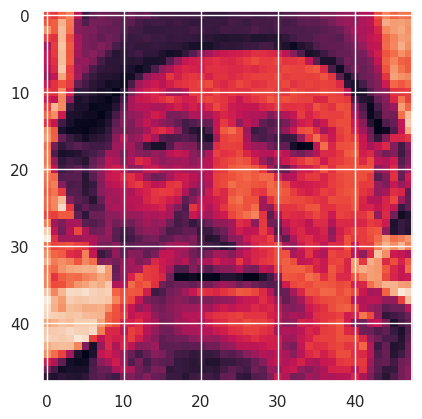

In [15]:
prediction('/kaggle/input/face-expression-recognition-dataset/images/validation/neutral/10346.jpg')

1/1 [==============================] - 0s 22ms/step
[0.05954848, 0.0008665496, 0.3444885, 0.0026453007, 0.31328824, 0.2096423, 0.06952067]


'Fear'

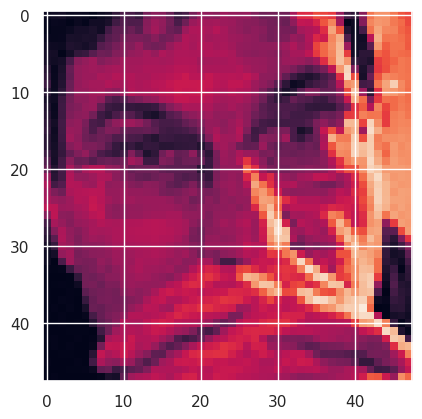

In [16]:
prediction('/kaggle/input/face-expression-recognition-dataset/images/validation/fear/10099.jpg')

1/1 [==============================] - 0s 22ms/step
[0.3377757, 0.00042792098, 0.09871083, 0.0006857256, 0.42056134, 0.13801707, 0.0038214254]


'Neutral'

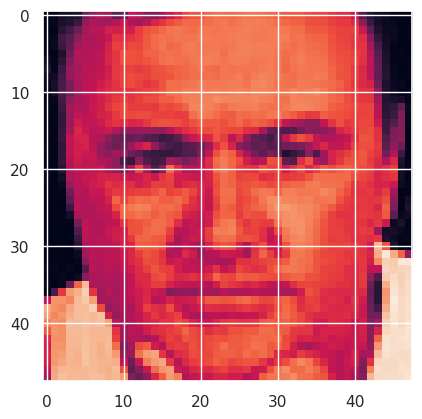

In [17]:
prediction('/kaggle/input/face-expression-recognition-dataset/images/validation/fear/10292.jpg')

we need some progress to overcome the overfitting

In [18]:
from keras.models import Sequential,load_model

In [19]:
model2=Sequential([
    Conv2D(64,(3,3),padding='same',activation='relu',input_shape=(48,48,1)),
    MaxPooling2D((2,2)),
    Conv2D(128,(3,3),padding='same',activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(256,(3,3),padding='same',activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(512,(3,3),padding='same',activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(512,activation='relu'),
    Dropout(0.5),
    Dense(7,activation='softmax')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 256)       295168    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 256)       

In [20]:
import keras
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5)
learning_rate_reduction=keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',patience=4,verbose=2,factor=0.25,min_lr=0.00001)
checkpoint=ModelCheckpoint("Model2.h5",monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')

In [21]:
model2.compile(
       optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
       loss='categorical_crossentropy',
       metrics=['accuracy'])

In [22]:
history=model2.fit(train_generator,
                  validation_data=test_generator,verbose=1,epochs=20,
                  callbacks=[early_stopping,learning_rate_reduction,checkpoint])

Epoch 1/20
451/451 [==============================] - ETA: 0s - loss: 1.8044 - accuracy: 0.2546
Epoch 1: val_accuracy improved from -inf to 0.31871, saving model to Model2.h5
451/451 [==============================] - 72s 154ms/step - loss: 1.8044 - accuracy: 0.2546 - val_loss: 1.7265 - val_accuracy: 0.3187 - lr: 1.0000e-04
Epoch 2/20
451/451 [==============================] - ETA: 0s - loss: 1.6736 - accuracy: 0.3352
Epoch 2: val_accuracy improved from 0.31871 to 0.38990, saving model to Model2.h5
451/451 [==============================] - 69s 153ms/step - loss: 1.6736 - accuracy: 0.3352 - val_loss: 1.5917 - val_accuracy: 0.3899 - lr: 1.0000e-04
Epoch 3/20
451/451 [==============================] - ETA: 0s - loss: 1.5692 - accuracy: 0.3910
Epoch 3: val_accuracy improved from 0.38990 to 0.41990, saving model to Model2.h5
451/451 [==============================] - 69s 153ms/step - loss: 1.5692 - accuracy: 0.3910 - val_loss: 1.5045 - val_accuracy: 0.4199 - lr: 1.0000e-04
Epoch 4/20
451/4

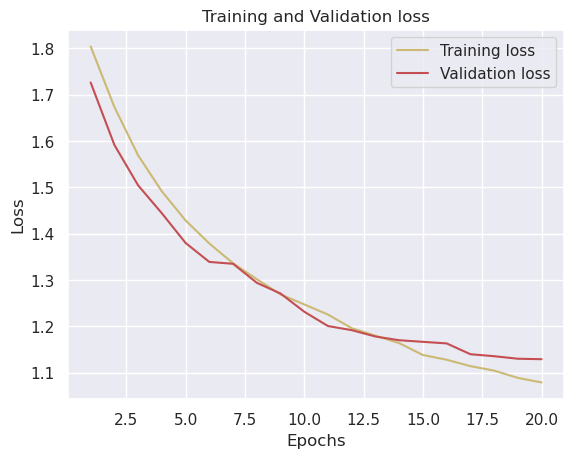

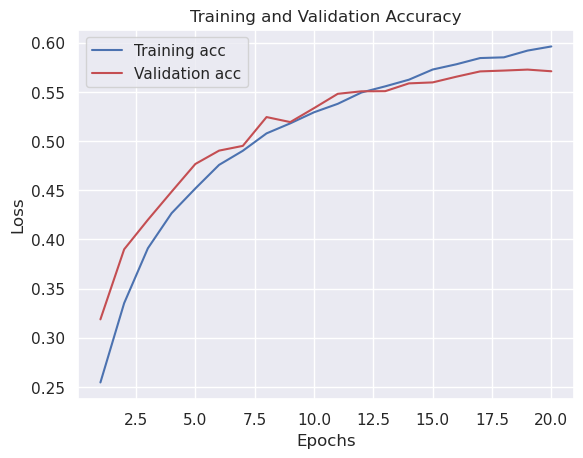

In [23]:
#plot the training and validation accuracy and loss at each epoch
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
plt.plot(epochs,acc,label='Training acc')
plt.plot(epochs,val_acc,'r',label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
our_model=load_model('Model2.h5')

In [25]:
train_loss,train_acc=our_model.evaluate(train_generator)
test_loss,valid_acc=our_model.evaluate(test_generator)

111/111 [==============================] - 14s 122ms/step - loss: 1.1272 - accuracy: 0.5849


In [26]:
def prediction1(url):
    img=plt.imread(url)
    plt.imshow(img)
    data=img_to_array(img)
    data=data/255
    data=tf.image.resize(data,(48,48))
    samples=np.expand_dims(data,0)
    samples=np.resize(samples,(1,48,48,1))
    result=our_model.predict(samples)
    result=list(result[0])
    print(result)
    predictions=label_dict[np.argmax(result)]
    return predictions

1/1 [==============================] - 0s 209ms/step
[0.0125050265, 0.000121617035, 0.060604274, 0.040639192, 0.00048121088, 0.0003602177, 0.8852884]


'Surprise'

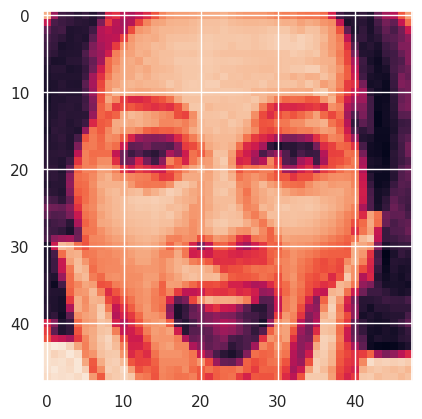

In [27]:
prediction1('/kaggle/input/face-expression-recognition-dataset/images/train/surprise/10011.jpg')

1/1 [==============================] - 0s 22ms/step
[0.14244321, 0.01629447, 0.10307423, 0.005546207, 0.3439127, 0.38540995, 0.0033192018]


'Sad'

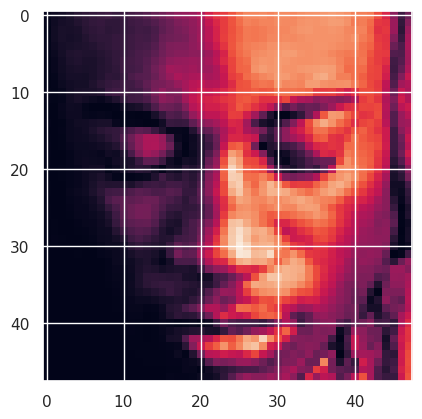

In [28]:
prediction1('/kaggle/input/face-expression-recognition-dataset/images/validation/sad/10339.jpg')

1/1 [==============================] - 0s 21ms/step
[0.25305945, 0.07905807, 0.09251672, 0.1125624, 0.31829807, 0.13568872, 0.008816497]


'Neutral'

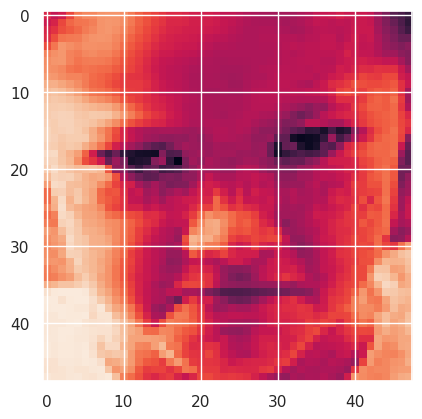

In [29]:
prediction1('/kaggle/input/face-expression-recognition-dataset/images/validation/angry/1024.jpg')

It's a bit better now

# Recommending a music

In [30]:
import pandas as pd
import cv2

In [31]:
mood_music=pd.read_csv('/kaggle/input/spotify-music-data-to-identify-the-moods/data_moods.csv')
mood_music=mood_music[['name','artist','mood']]
mood_music.head()

,name,artist,mood
0,1999,Prince,Happy
1,23,Blonde Redhead,Sad
2,9 Crimes,Damien Rice,Sad
3,99 Luftballons,Nena,Happy
4,A Boy Brushed Red Living In Black And White,Underoath,Energetic


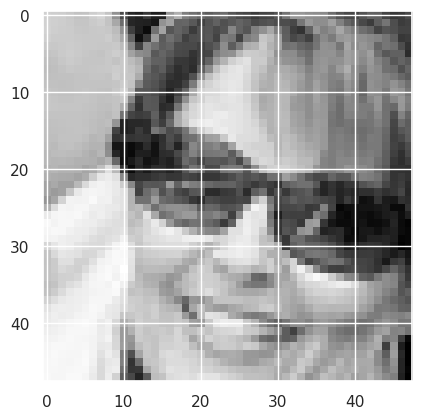

In [32]:
image=cv2.imread('/kaggle/input/face-expression-recognition-dataset/images/train/happy/10060.jpg',cv2.IMREAD_GRAYSCALE)

plt.imshow(image,cmap='gray')
plt.show()

In [33]:
image=cv2.resize(image,(48,48))
img=np.array(image)
img=img.reshape(1,48,48,1)
predict_x=model2.predict(img)
result=np.argmax(predict_x,axis=1)
result[0]

1/1 [==============================] - 0s 106ms/step


3

In [34]:
if(result[0]==0 or result[0]==1 or result[0]==2):
    #for angry,disgust,fear
    filter1=mood_music['mood']=='Calm'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2=f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==3 or result[0]==4):
    #for happy,neutral
    filter1=mood_music['mood']=='Happy'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2=f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==5):
    #for sad
    filter1=mood_music['mood']=='Sad'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2=f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==6):
    #for surprise
    filter1=mood_music['mood']=='Energetic'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2=f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)

,index,name,artist,mood
0,149,Down On The Corner,Creedence Clearwater Revival,Happy
1,536,Teardrops - Single Version,Various Artists,Happy
2,589,Twist And Shout - Remastered 2009,The Beatles,Happy
3,7,A Little Less Conversation - JXL Radio Edit Remix,Elvis Presley,Happy
4,323,Lonely Boy,Andrew Gold,Happy


Hope this additional feature is nice